In [74]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

def get_ohe():
    ohe_kwargs = {'handle_unknown': 'ignore'}
    skl_version = tuple(map(int, sklearn.__version__.split('.')[:2]))
    if skl_version >= (1,2):
        ohe_kwargs['sparse_output'] = False
    else:
        ohe_kwargs['sparse'] = False
    return OneHotEncoder(**ohe_kwargs)


In [75]:
FILE_PATH = "/content/adult 3 (1).csv"

df = pd.read_csv(FILE_PATH)
df = df.replace('?', np.nan)

selected_features = [
    'age', 'workclass', 'education', 'educational-num',
    'occupation', 'capital-gain', 'capital-loss', 'hours-per-week'
]

df_model = df[selected_features + ['income']]

print("Feature columns used:", selected_features)
print(df_model.info())
print(df_model.describe())
print(df_model['income'].value_counts())


Feature columns used: ['age', 'workclass', 'education', 'educational-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   education        48842 non-null  object
 3   educational-num  48842 non-null  int64 
 4   occupation       46033 non-null  object
 5   capital-gain     48842 non-null  int64 
 6   capital-loss     48842 non-null  int64 
 7   hours-per-week   48842 non-null  int64 
 8   income           48842 non-null  object
dtypes: int64(5), object(4)
memory usage: 3.4+ MB
None
                age  educational-num  capital-gain  capital-loss  \
count  48842.000000     48842.000000  48842.000000  48842.000000   
mean      38.643585        10.078089   1079.067626     87.502314   

In [76]:
df_model['income'] = df_model['income'].astype(str).str.strip()
counts = df_model['income'].value_counts()
rare_classes = counts[counts < 2].index
if len(rare_classes) > 0:
    print(f"Removing rare classes: {list(rare_classes)}")
    df_model = df_model[~df_model['income'].isin(rare_classes)]


/tmp/ipython-input-76-2768812916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['income'] = df_model['income'].astype(str).str.strip()


In [77]:
X = df_model[selected_features]
y = df_model['income']

le = LabelEncoder()
y = le.fit_transform(y.astype(str))

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()


In [78]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", get_ohe())
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])


In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [80]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

params = {
    "LogisticRegression": {"classifier__C": [0.3, 1, 3]},
    "RandomForest": {"classifier__n_estimators": [50, 100], "classifier__max_depth": [8, 15]}
}



--- Training: LogisticRegression ---
Accuracy: 0.8232162964479476
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7431
           1       0.73      0.42      0.53      2338

    accuracy                           0.82      9769
   macro avg       0.78      0.68      0.71      9769
weighted avg       0.81      0.82      0.80      9769



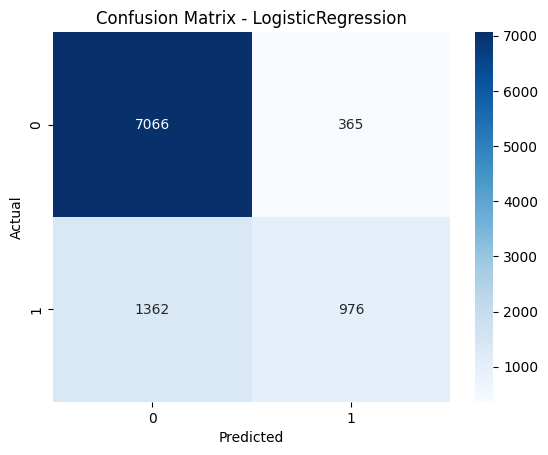

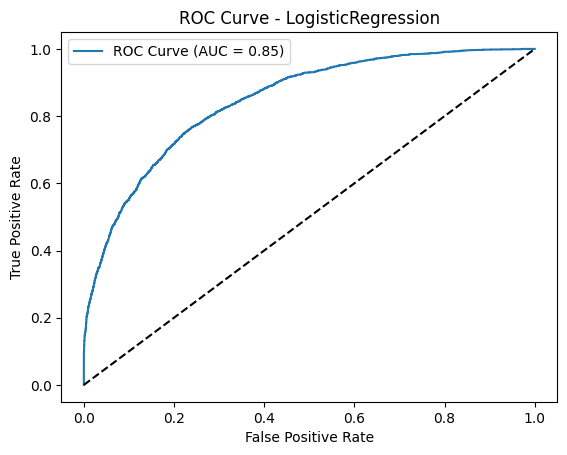


--- Training: RandomForest ---
Accuracy: 0.8409253761899887
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      7431
           1       0.81      0.44      0.57      2338

    accuracy                           0.84      9769
   macro avg       0.83      0.70      0.74      9769
weighted avg       0.84      0.84      0.82      9769



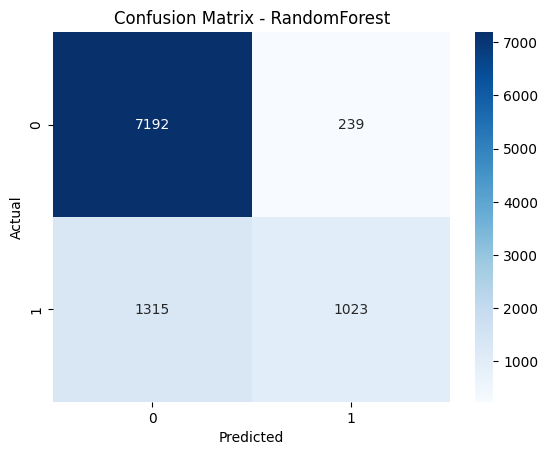

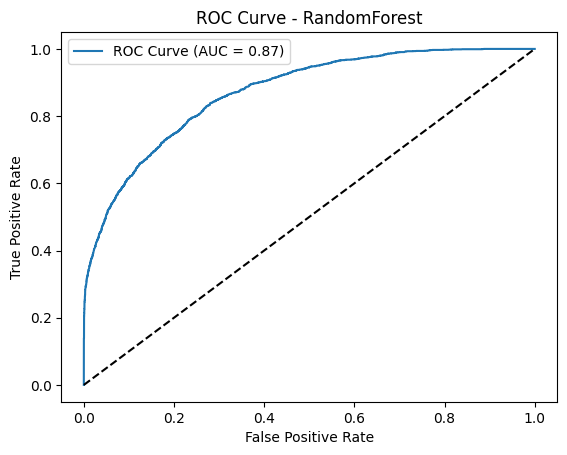

In [81]:
results = {}

for name, model in models.items():
    print(f"\n--- Training: {name} ---")
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    grid = GridSearchCV(pipe, params[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    results[name] = grid.best_estimator_

    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    if len(np.unique(y_test)) == 2:
        y_proba = grid.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()


In [82]:
import joblib
final_clf = results["RandomForest"]
joblib.dump(final_clf, "salary_model.pkl")


['salary_model.pkl']

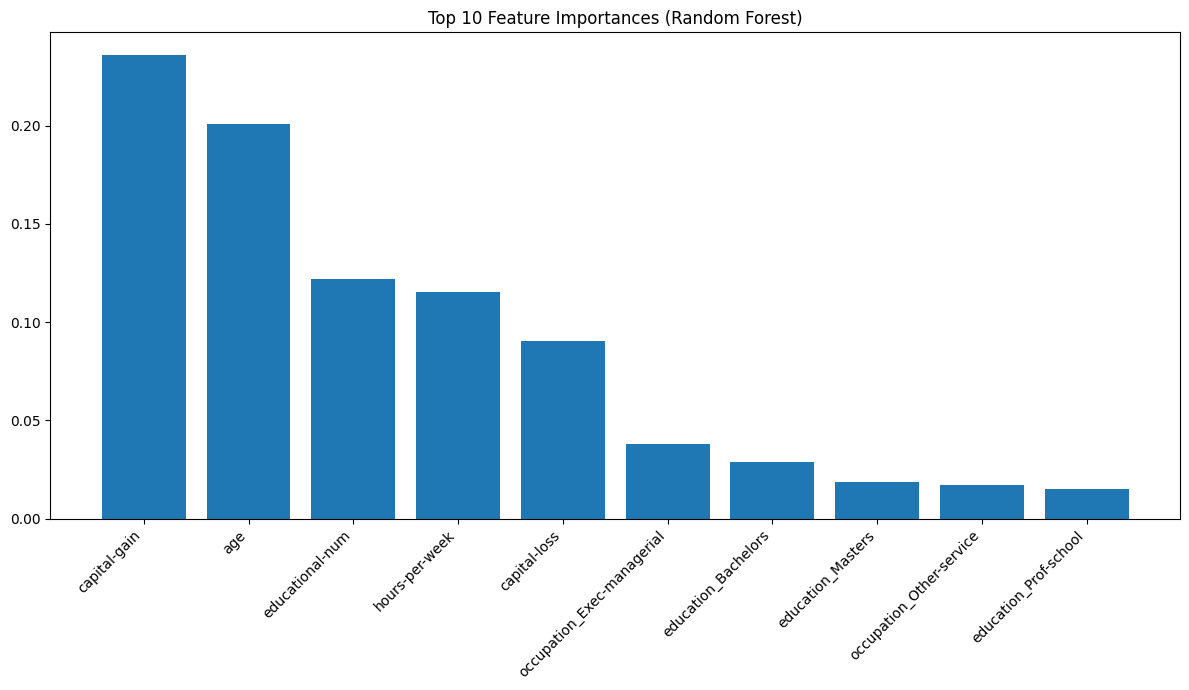

Top features:
capital-gain: 0.2357
age: 0.2009
educational-num: 0.1217
hours-per-week: 0.1152
capital-loss: 0.0902
occupation_Exec-managerial: 0.0381
education_Bachelors: 0.0287
education_Masters: 0.0186
occupation_Other-service: 0.0173
education_Prof-school: 0.0152


In [83]:
if hasattr(final_clf.named_steps["classifier"], "feature_importances_"):
    ohe = final_clf.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
    feature_names = np.concatenate([
        numerical_cols,
        ohe.get_feature_names_out(categorical_cols)
    ])
    importances = final_clf.named_steps["classifier"].feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12,7))
    plt.title("Top 10 Feature Importances (Random Forest)")
    plt.bar(range(10), importances[indices][:10])
    plt.xticks(range(10), feature_names[indices][:10], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("Top features:")
    for i in range(10):
        print(f"{feature_names[indices][i]}: {importances[indices][i]:.4f}")


In [84]:
example = X_test.iloc[[10]]
example_pred = final_clf.predict(example)
example_proba = final_clf.predict_proba(example)

print("\nExample input row:")
print(example)
print("Predicted income class:", le.inverse_transform(example_pred)[0])
print("Class probabilities:", example_proba[0])



Example input row:
       age workclass  education  educational-num      occupation  \
38546   42   Private  Doctorate               16  Prof-specialty   

       capital-gain  capital-loss  hours-per-week  
38546             0             0              40  
Predicted income class: >50K
Class probabilities: [0.36699953 0.63300047]


In [85]:
salary_map = {
    '<=50K': 32000,
    '>50K': 70000
}

class_labels = le.classes_
salary_values = np.array([salary_map[label] for label in class_labels])

estimated_salary = np.dot(example_proba[0], salary_values)
print(f"Estimated salary (weighted by class probabilities): ₹{estimated_salary:,.2f} per month")


Estimated salary (weighted by class probabilities): ₹56,054.02 per month


In [86]:
!pip install streamlit pyngrok

In [99]:
from google.colab import userdata
token=userdata.get('ngrok')

In [104]:
from pyngrok import ngrok


ngrok.set_auth_token(token)


In [105]:
import threading
import os


os.system("kill -9 $(lsof -t -i:8501)")


def run():
    os.system('streamlit run app.py --server.port 8501')


threading.Thread(target=run).start()


In [106]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib


model = joblib.load('salary_model.pkl')
SALARY_MAP = {'<=50K': 25000, '>50K': 150000}


st.markdown("""
    <style>
        /* Titles - white font, no background change */
        .big-title {
            font-size: 2.5rem !important;
            color: white !important;
            text-align: center !important;
            font-weight: 800;
            padding-top: 0.6rem;
            font-family: 'Segoe UI', Verdana, sans-serif;
            background-color: transparent !important;
        }
        .subtitle {
            font-size: 1.12rem !important;
            color: white !important;
            font-weight: 600;
            text-align: center;
            margin-bottom: 1.3em;
            background-color: transparent !important;
        }

        /* Result card background stays as is, but font colors updated */
        .result-card {
            background-color: #f4f8fb;
            padding: 17px 32px 20px 32px;
            border-radius: 14px;
            box-shadow: 0 3px 17px #e2e8f0;
            text-align: center;
            margin-bottom: 22px;
            color: black !important;  /* keep text dark here for readability */
        }
        .result-range {
            font-size: 1.5rem !important;
            color: #2563eb;
            font-weight: 800;
            letter-spacing: 0.03em;
            margin-bottom: 7px;
        }
        .est-class {
            font-size: 1.15rem !important;
            font-weight: 700;
            color: #006A51;
            margin-bottom: 11px;
        }
        .advice-box {
            background-color: #e3edfa;
            padding: 13px 20px;
            border-radius: 9px;
            font-size: 1.08rem;
            color: #21243d;
            margin-top: 13px;
            margin-bottom: 7px;
            border-left: 5px solid #2563eb;
        }

        /* Input tip text - white font, no background */
        .input-tip {
            color: white !important;
            font-size: 1.00rem;
            margin-bottom: 7px;
            margin-top: -7px;
            background-color: transparent !important;
        }

        /* Sidebar or Metric label/value color tweak (optional) */
        .stMetricLabel {
            font-size: 1.05rem !important;
            color: white !important;
        }
        .stMetricValue {
            color: white !important;
            font-size: 1.2rem !important;
        }

        /* Progress bar color */
        .stProgress > div > div > div > div {
            background-color: #2563eb !important;
        }

        /* Override main app background if you want dark background to see white font clearly */
        .main > div {
            background-color: transparent !important;
        }
    </style>
""", unsafe_allow_html=True)

st.set_page_config(page_title="Employee Salary Predictor", layout="wide")


st.sidebar.title("🔎 Navigation")
page = st.sidebar.radio(
    "Go to", ("Home", "Single Salary Prediction")
)


if page == "Home":
    st.markdown('<div class="big-title">💼 Employee Salary Predictor</div>', unsafe_allow_html=True)
    st.markdown("""
    <div class="subtitle">
    Instantly estimate employee salary bands and monthly pay using smart ML.<br>
    <span >Fast, simple, for all HR and job-seekers.</span>
    </div>
    """, unsafe_allow_html=True)
    st.markdown("""
    <div style="background-color:#e3edfa;padding:17px 26px;border-radius:13px;
                box-shadow:0 2px 8px #eaf1fb;margin-bottom:19px; color: black;">
    <b>How to Use:</b><br>
    1. Select <b>Single Salary Prediction</b> in the sidebar.<br>
    2. Enter employee details (see below for field tips).<br>
    3. Click <b>Predict</b> for instant salary range and estimate.
    </div>
    """, unsafe_allow_html=True)
    st.markdown("---")
    st.markdown("""### 📋 Input Parameter Quick Reference""")
    st.markdown("""
    <div style="font-size:1.03rem; color: white;">
    <ul>
        <li><b>Age:</b> Years old (17–90).</li>
        <li><b>Workclass:</b> Employer type (Private, Self-Employed, Government, etc).</li>
        <li><b>Education:</b> Highest qualification (e.g. Bachelors, 12th, Masters, etc).</li>
        <li><b>Education Number:</b> Total (1–16) years in formal education.</li>
        <li><b>Occupation:</b> Work type (Sales, Tech-support, Farming, Management, etc).</li>
        <li><b>Capital Gain:</b> Yearly non-salary profit (ex: investments). 0 if none.</li>
        <li><b>Capital Loss:</b> Yearly non-salary loss (ex: investments). 0 if none.</li>
        <li><b>Hours worked/week:</b> Typical weekly hours (1–99).</li>
    </ul>
    </div>
    """, unsafe_allow_html=True)
    st.info("Use the sidebar ⬅️ to start predicting.")


elif page == "Single Salary Prediction":
    st.markdown('<div class="big-title">Single Employee Salary Prediction</div>', unsafe_allow_html=True)
    st.write("Fill in each field. (Field tips shown below each input; see 'Quick Reference' on Home tab for details.)")
    st.markdown("---")
    with st.form("features"):
        col1, col2 = st.columns(2)
        with col1:
            age = st.number_input(
                "Age", 17, 90, 30,
                help="Employee's age (17–90)."
            )
            st.markdown('<div class="input-tip">Employee age in years.</div>', unsafe_allow_html=True)
            workclass = st.selectbox(
                "Workclass",
                ['Private','Self-emp-not-inc','Self-emp-inc','Federal-gov','Local-gov',
                 'State-gov','Without-pay','Never-worked'],
                help="Type of employer."
            )
            st.markdown('<div class="input-tip">Employer type (e.g. Private, Self-employed).</div>', unsafe_allow_html=True)
            education = st.selectbox(
                "Education",
                sorted(['Bachelors','HS-grad','11th','Masters','9th','Some-college','Assoc-acdm','Assoc-voc',
                        '7th-8th','Doctorate','Prof-school','5th-6th','10th','1st-4th','Preschool','12th']),
                help="Highest qualification."
            )
            st.markdown('<div class="input-tip">E.g.: Bachelors, 12th, Masters, etc.</div>', unsafe_allow_html=True)
            educational_num = st.slider(
                "Education Number", 1, 16, 10,
                help="Total formal education years."
            )
            st.markdown('<div class="input-tip">Years in formal schooling or college.</div>', unsafe_allow_html=True)
        with col2:
            occupation = st.selectbox(
                "Occupation",
                sorted(['Tech-support','Craft-repair','Other-service','Sales','Exec-managerial',
                        'Prof-specialty','Handlers-cleaners','Machine-op-inspct','Adm-clerical',
                        'Farming-fishing','Transport-moving','Priv-house-serv',
                        'Protective-serv','Armed-Forces']),
                help="Main job/role type."
            )
            st.markdown('<div class="input-tip">E.g.: Sales, Manager, Tech Support, etc.</div>', unsafe_allow_html=True)
            capital_gain = st.number_input(
                "Capital Gain", 0, 100000, 0, step=500,
                help="Non-salary profit per year."
            )
            st.markdown('<div class="input-tip">Annual investment profit. 0 if none.</div>', unsafe_allow_html=True)
            capital_loss = st.number_input(
                "Capital Loss", 0, 5000, 0, step=100,
                help="Non-salary loss per year."
            )
            st.markdown('<div class="input-tip">Annual investment loss. 0 if none.</div>', unsafe_allow_html=True)
            hours_per_week = st.slider(
                "Hours worked per week", 1, 99, 40,
                help="Usual weekly working hours."
            )
            st.markdown('<div class="input-tip">Typical work hours a week.</div>', unsafe_allow_html=True)
        submit = st.form_submit_button("🔮 Predict Salary Range")

    if submit:
        X = pd.DataFrame([{
            "age": age, "workclass": workclass, "education": education,
            "educational-num": educational_num, "occupation": occupation,
            "capital-gain": capital_gain, "capital-loss": capital_loss,
            "hours-per-week": hours_per_week
        }])
        probs = model.predict_proba(X)[0]
        salary = float(np.dot(probs, [SALARY_MAP['<=50K'], SALARY_MAP['>50K']]))

        if salary < 50000:
            estimator_class = '< 50K'
            display_range = "₹25,000 – <₹50,000"
            advice = "🔎 <b>Salary likely on the lower side.</b> Consider upskilling or new roles for higher pay."
        else:
            estimator_class = '> 50K'
            display_range = "₹50,000 – ₹1,50,000"
            advice = "🚀 <b>Great prospects!</b> Salary is expected to be above ₹50,000. Keep enhancing your skills!"

        st.markdown("---")
        st.markdown(f"<div class='result-card'>"
                    f"<div class='result-range'>Salary Range: {display_range}</div>"
                    f"<div class='est-class'>Estimator-Driven Salary Class: {estimator_class}</div>"
                    f"</div>", unsafe_allow_html=True)
        st.metric("Estimated Salary (₹ / month)", f"{salary:,.0f}")
        st.progress(probs[1])
        st.caption(f"Probability (model) of high salary: {probs[1]*100:.1f}%")
        with st.expander("🔍 Show Inputs Used"):
            st.dataframe(X)
        st.markdown(f"<div class='advice-box'>{advice}</div>", unsafe_allow_html=True)



Overwriting app.py


In [107]:
import threading, os
from pyngrok import ngrok


os.system("kill -9 $(lsof -t -i:8501)")


def run():
    os.system("streamlit run app.py --server.port 8501")
threading.Thread(target=run).start()


public_url = ngrok.connect(8501)
print(f"Streamlit App URL: {public_url}")

Streamlit App URL: NgrokTunnel: "https://89859ec6a901.ngrok-free.app" -> "http://localhost:8501"
